# Credit Card Transaction Fraud Detection

![fraud-image](https://images.unsplash.com/photo-1637021536343-03a48e01a34c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=870&q=80)

## Problem Statement
With the growth of e-commerce websites, people and financial companies rely on online services to carry out their transactions that have led to an exponential increase in the credit card frauds. Fraudulent credit card transactions lead to a loss of huge amount of money. The design of an effective fraud detection system is necessary in order to reduce the losses incurred by the customers and financial companies.

**In this sense, in this project, we develop a Machine learning model(XGBoost) to detect credit card transaction fraud and implement it as a web service.**

**Author: Luis Fernando Salazar S.  Date: 21/10/2022**

### **Credit Card Fraud**

Credit card transaction is a syntetic financial dataset created using a simulator called PaySim. In this sense, PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

This dataset contain:
  - 6362620 observations
  - 11 variables (included the target variable) 


###  **Install and import libraries**

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [ ]:
!pip install missingno

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install hyperopt

In [ ]:
!pip install xgboost --upgrade

In [ ]:
!pip install PDPbox

In [ ]:
#import libraries
import os
import joblib
import zipfile
import warnings
warnings.simplefilter(action = "ignore")

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 

import numpy as np
import pandas as pd
import scipy

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import missingno as msno
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb
#import xgboost as xgb

### **Get the Data**

In [ ]:
# Connect with google dirve
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
## Unzipfile
filepath = "/content/drive/MyDrive/Fraud_detection/Fraud_detection.zip"
with zipfile.ZipFile(filepath, "r") as file:
  file.extractall("/tmp")

### **Exploratory data analysis(EDA)**

- Structure
- Quality
- Content
- Patters

#### Structure
- General dimension of the dataset
- types of variables

In [ ]:
# import file and get basic information
df = pd.read_csv("/tmp/PS_20174392719_1491204439457_log.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Shape 
print(f"Data shape:{df.shape}")
df.head(4)

Data shape:(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0


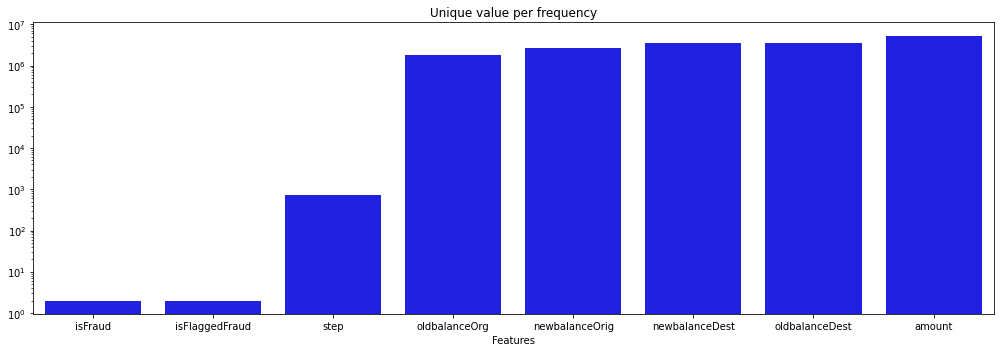

In [ ]:
# Unique value - numerical variables
unique_value = df.select_dtypes("number").nunique().sort_values()

# bar Plot
fig, ax = plt.subplots(figsize = (14, 5))
sns.barplot(x = unique_value.index, y = unique_value, color = 'Blue', ax = ax)
ax.set_yscale("log")
ax.set_xlabel("Features")
ax.set_title("Unique value per frequency")
plt.tight_layout();

#### Quality
- Duplicate values
- Missing values
- outlier values

In [ ]:
# Detection duplicate value
duplicate_value = df.duplicated().sum()

print(f"In this dataset there are {duplicate_value} duplicate values")

In this dataset there are 0 duplicate values


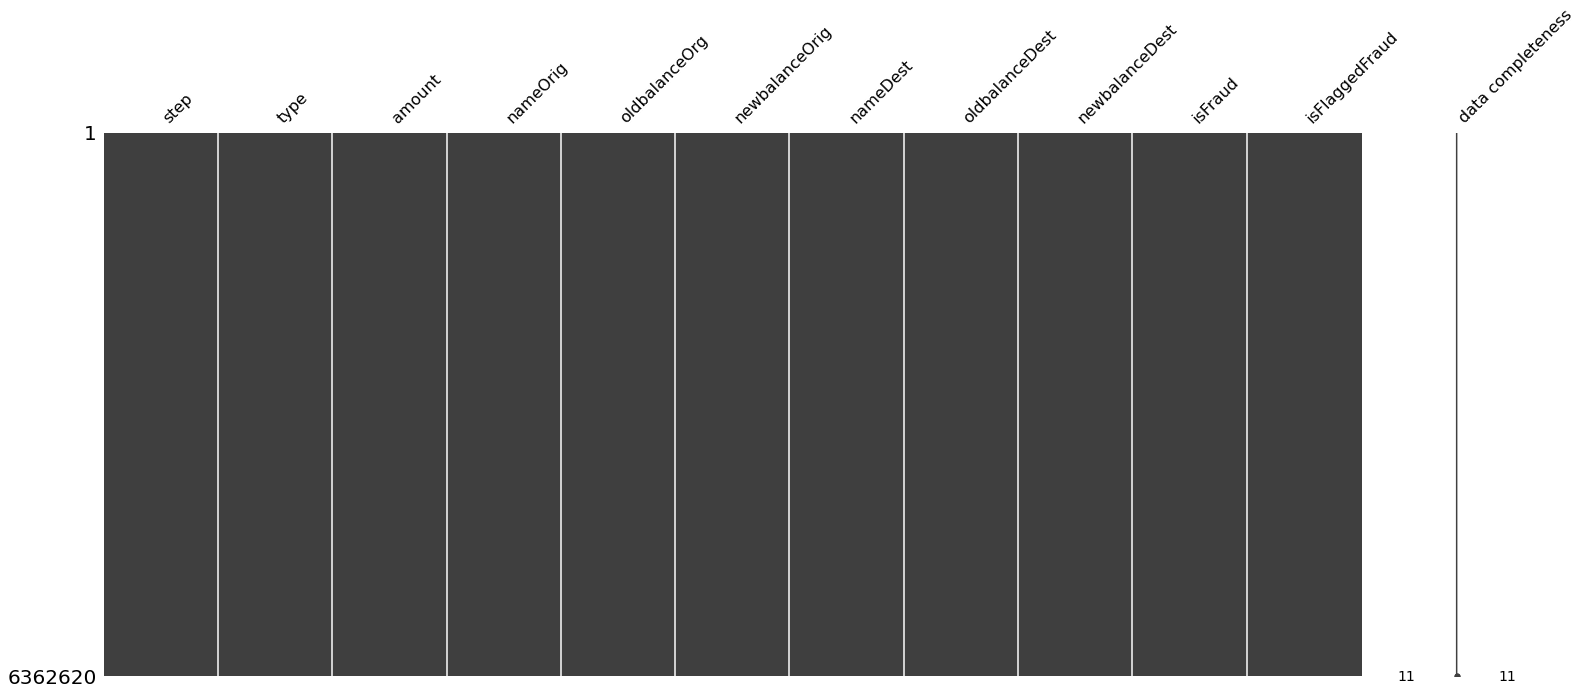

In [ ]:
## Missing values by samples
msno.matrix(df, labels = True, sort = "descending");

In [ ]:
## Outlier detection

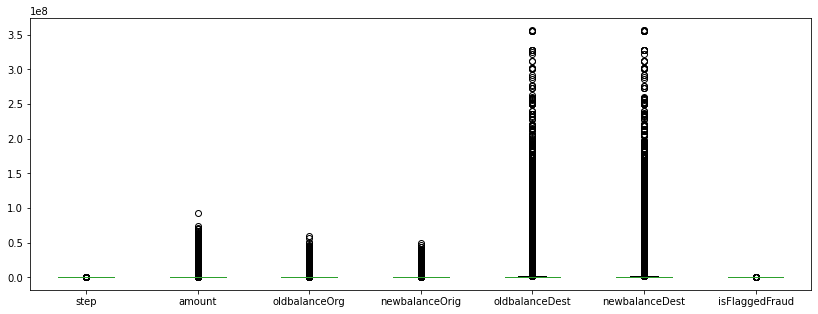

In [ ]:
## Boxplot
df.drop(columns = "isFraud").boxplot(grid = False, 
                                     figsize = (14, 5),
                                     );

In [ ]:
# #Features
# features = df.select_dtypes("number").drop(columns = ["isFraud", "scores"])
# ## IsolateForest
# isolation_model = IsolationForest(
#     contamination = float(0.2),
#     random_state = np.random.seed(42),
#     n_jobs = -1
# )
# isolation_model.fit(features)

# df['scores'] = isolation_model.decision_function(features) 
# df['anomaly_score'] = isolation_model.predict(features)
# df.head(4)

# # plot of anomalies
# fig, ax = plt.subplots(figsize = (14,5))
# df['anomaly_score'].value_counts().plot(
#     kind = "bar",
#     ylabel = "Frequency",
#     title = "Anomalies frequency",
#     ax = ax
# )
# ax.set_yscale('log')
# #ax.set_xticklabels(["Normal: 1","Anomaly: -1"]);

In [ ]:
# Clean dataset
def filter_merchants_users(data):
  data = df[df['nameDest'].str.contains("M") == False]
  data.reset_index(drop = True, inplace = True)
  return  data

def unnecessary_var(data):
  drop_list = ['nameOrig','isFlaggedFraud', 'nameDest']
  data.drop(columns = drop_list, inplace = True)
  return data

In [ ]:
## Deep copy
df_copy = df.copy(deep = True)

In [ ]:
# pandas pipeline
df_m = (
    df_copy
    .pipe(filter_merchants_users)
    .pipe(unnecessary_var)
)
print(df_m.shape)
df_m.head(4)

(4211125, 8)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,181.0,0.00,0.0,0.00,1
1,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.00,1
2,1,DEBIT,5337.77,41720.0,36382.23,41898.0,40348.79,0
3,1,DEBIT,9644.94,4465.0,0.00,10845.0,157982.12,0


#### Content
- Summary statistic (numerical and categorical vaaibles)
- Variable distributions
- Skew and kurtosis

In [ ]:
## summary statistic (numerical variables)
df.describe().T

In [ ]:
# categorical variables
df.describe(include = "object")

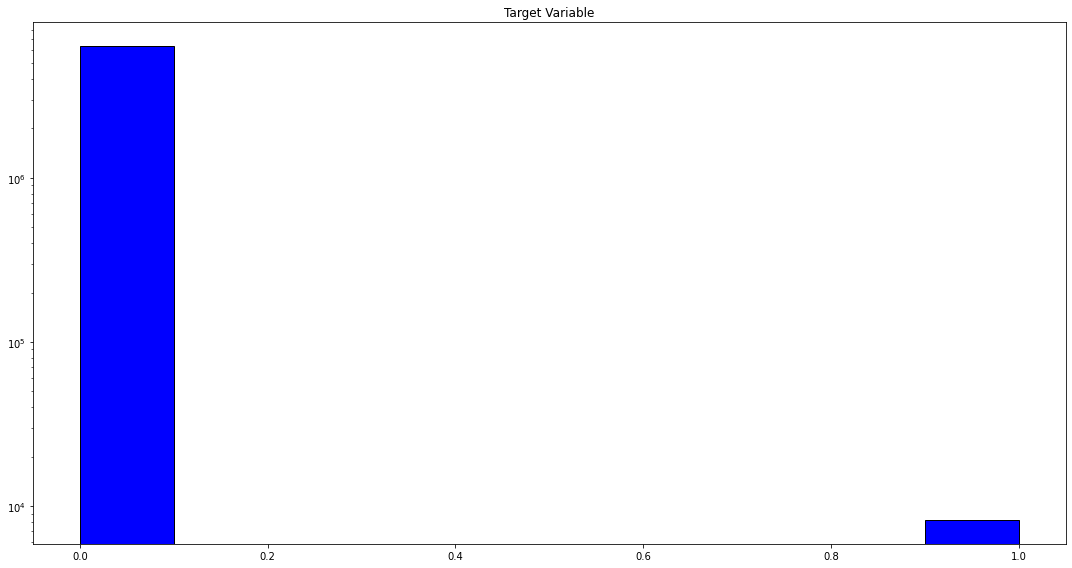

In [ ]:
# Target distribution
df['isFraud'].hist(figsize = (15, 8),
                       color = "blue",
                       grid = False,
                       edgecolor = "black")
plt.yscale("log")
plt.title("Target Variable")
plt.tight_layout();

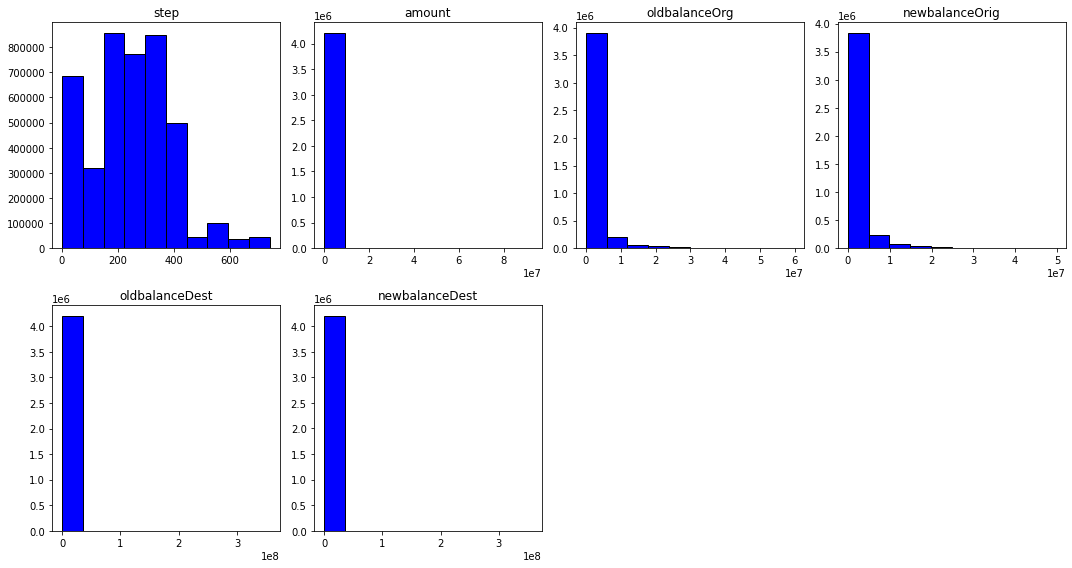

In [ ]:
# Feature distributions
df_m.drop(columns = 'isFraud').hist(bins = 10,
                                      figsize = (15, 8),
                                      layout = (-1, 4),
                                      grid = False,
                                      color = "blue",
                                      edgecolor = "black",
                                      )
plt.tight_layout();

In [ ]:
# Kurtosis and skew
num_features = [colm for colm in df_m.select_dtypes("number").columns if colm != "isFraud"]

for c in num_features:
    kurt = scipy.stats.mstats.kurtosis(df[c])
    Skew = scipy.stats.mstats.skew(df[c])
    
    print(f"{c} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

step Skew: 0.38, Kurtosis: 0.33
amount Skew: 30.99, Kurtosis: 1797.96
oldbalanceOrg Skew: 5.25, Kurtosis: 32.96
newbalanceOrig Skew: 5.18, Kurtosis: 32.07
oldbalanceDest Skew: 19.92, Kurtosis: 948.67
newbalanceDest Skew: 19.35, Kurtosis: 862.16
isFraud Skew: 27.78, Kurtosis: 769.7


#### Patters
- Pairplots
- Correlation coefficient
 - Pearson
 - Spearman
- Boxplot (Fraud per time of transaction)
- Risk of fraud per type of pay

In [ ]:
## Feature patters
feat_continues = df_m.select_dtypes("number").drop(columns = ["isFraud", "type"])

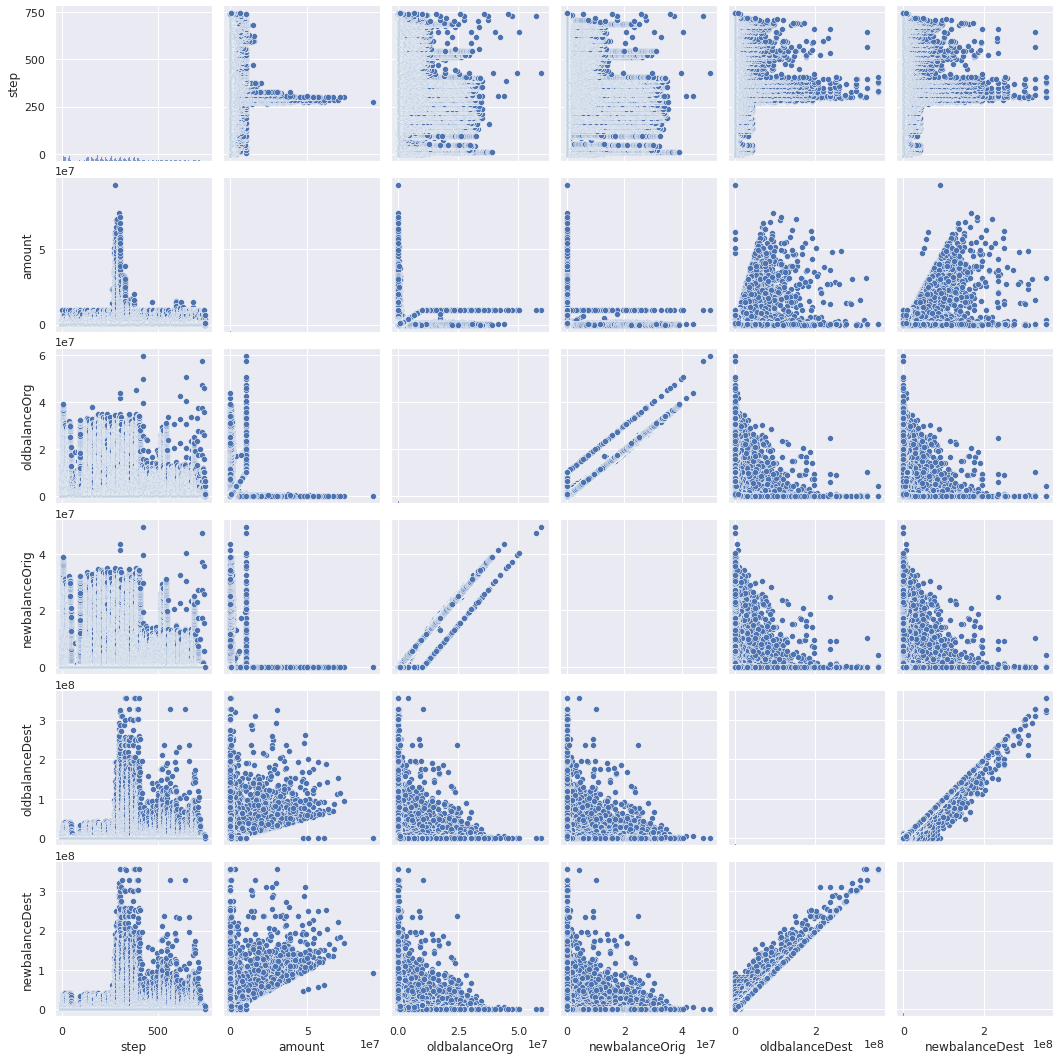

In [ ]:
## pairplot
sns.set(rc={'figure.figsize':(14,8)})
sns.pairplot(feat_continues)
sns.set_context('talk')
sns.set_style('white')

In [ ]:
## Correlaction (pearson and spermean)
pearson_corr = df_m.corr(method = 'pearson')
spearman_corr = df_m.corr(method = 'spearman')

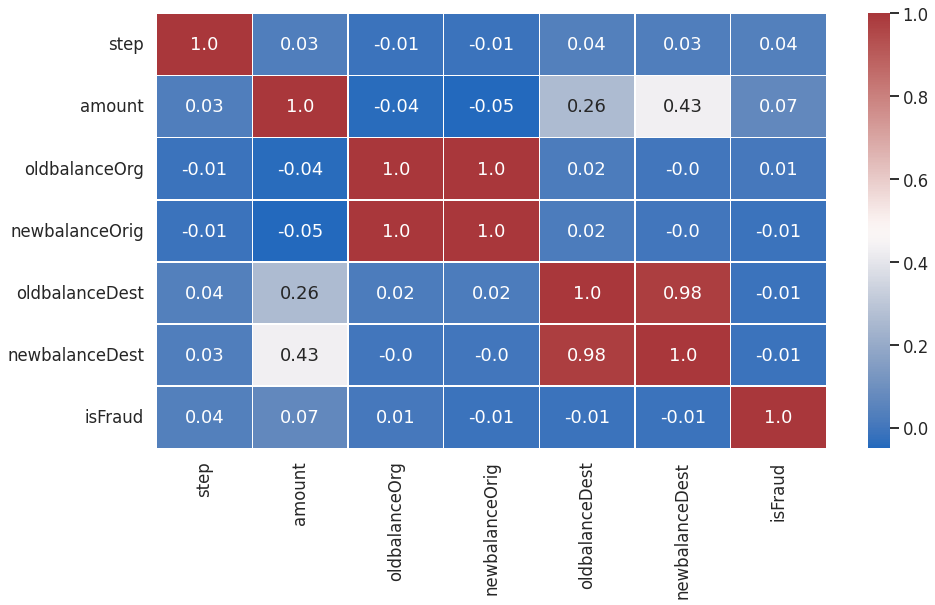

In [ ]:
# Correlation plot
fig, ax = plt.subplots(figsize=(15,8))
#pearson
sns.heatmap(np.round(pearson_corr, 2),
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax
              );

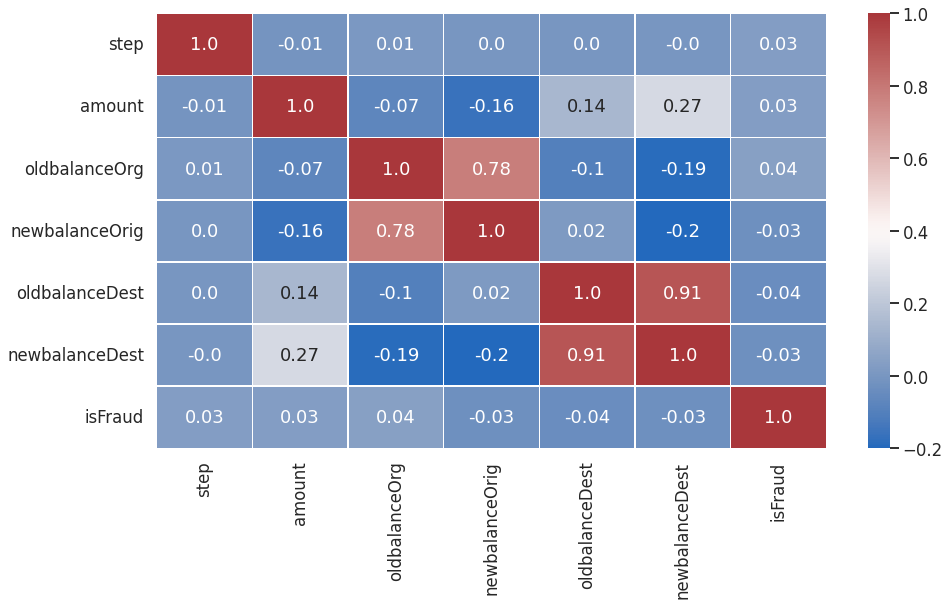

In [ ]:
#spearman
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(np.round(spearman_corr, 2), square = False,
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax
              );#mask = np.eye(len(spearman_corr)),cbar_kws = {"shrink": 0.8}

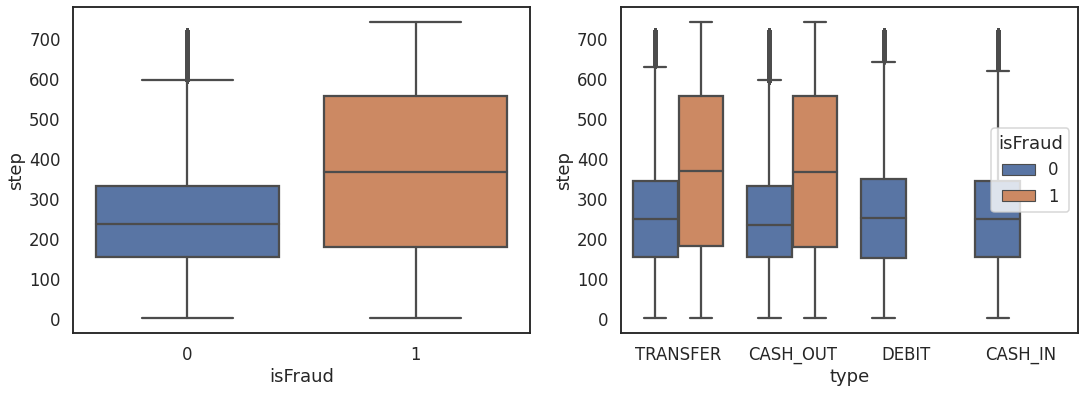

In [ ]:
## Boxplot per step (time of transaction)
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax.ravel()

## Fraud per amount of transactions
sns.boxplot(
    data = df_m,
    x = 'isFraud',
    y = 'step',
    ax = ax[0]
)
## type of pay
sns.boxplot(
    data = df_m,
    x = 'type',
    y = 'step',
    hue = 'isFraud',
    ax = ax[1]
);

In [ ]:
from IPython.display import display
## Risk of fraud per type of pay
global_mean = df_m['isFraud'].mean()
## calculate risk
type_group = pd.DataFrame() 
type_group['mean'] = df_m.groupby('type')['isFraud'].mean()
type_group['diff'] = type_group['mean'] - global_mean
type_group['risk'] = type_group['mean'] / global_mean
display(type_group)

,mean,diff,risk
type,,,
CASH_IN,0.000000,-0.001950,0.000000
CASH_OUT,0.001840,-0.000111,0.943211
DEBIT,0.000000,-0.001950,0.000000
TRANSFER,0.007688,0.005738,3.941933


### Data Preprocessing
- Transform categorical variables
- Split data into features(X) and label(y)
- Split data in train, val and test set

In [ ]:
## Transform type variable 
type_dict = {
    
    'PAYMENT': 0,
    'TRANSFER': 1,
    'CASH_OUT': 2,
    'DEBIT': 3,
    'CASH_IN': 4
}
df_m['type'] = df_m['type'].map(type_dict)

In [ ]:
### Data preprocessing 

In [ ]:
label = 'isFraud'
X = df_m.drop(label, axis = 1)
y = df_m[label]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (4211125, 7)
Labels shape: (4211125,)


In [ ]:
# split the data into train, val and test set
def train_test_val_split(features, labels, split_train, split_val):

  # Split and get index
  train_idx_f, test_idx = next(split_train.split(features, labels))

  # first x and y train set
  X_train_f = features.iloc[train_idx_f]
  y_train_f = labels.iloc[train_idx_f]

  # X and y test set
  X_test = features.iloc[test_idx]
  y_test = labels.iloc[test_idx]

  # Second Split and get index
  train_idx, val_idx = next(split_val.split(X_train_f, y_train_f))

  # X and y train set (definitive)
  X_train = features.iloc[train_idx]
  y_train = labels.iloc[train_idx]

  # X and y validation set
  X_val = features.iloc[val_idx]
  y_val = labels.iloc[val_idx]

  return X_train, y_train, X_test, y_test, X_val, y_val


In [ ]:
split_train = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.2,
                                     random_state = np.random.seed(42)
                                     )
split_val = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.25,
                                     random_state = np.random.seed(42)
                                     )

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y,split_train, split_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2526675, 7)
X_val shape:(842225, 7)
X_test shape:(842225, 7)
y_train shape: (2526675,)
y_val shape: (842225,)
y_test shape: (842225,)


In [ ]:
# # OverSampling (SMOTE) method to unbalance data
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek
# def oversampling(alg, X, y):
    
#     alg_over = alg(random_state = np.random.seed(42), n_jobs = -1)
  
#     X_train_over, y_train_over = alg_over.fit_resample(X, y)
    
#     return X_train_over, y_train_over

In [ ]:
# X_train, y_train = oversampling(SMOTETomek, X_train, y_train) 

# print(f"X train over shape: {X_train.shape}")
# print(f"y train over shape: {y_train.shape}")

### **Modelling**
- Base line model
 - LogisticRegression

- Models:
 - RandomForest
 - LightGBM
 - XGBoost

- Models performance with the validation set:
 - Accuracy
 - Precision
 - Recall
 - F1 Score
 - Roc-auc

- Hyperparameter tuning - Final model:
 - hyperopt- Bayesian search strategy

- Final model performance with the test set:
 - Cofusion matrix
 - Accuracy
 - F1 Score
 - Roc curve

- Final model - Feature importances


 



#### Funtion to evaluate the performance of the models 

In [ ]:
#Funtion: performance of the model with the validation set
def model_performance_val(y_val, y_pre):
  #classification report
  cl_report = classification_report(y_val, y_pre)
  # scores
  scores = pd.DataFrame(
      {
       'accuracy': accuracy_score(y_val, y_pre),
       'precision': precision_score(y_val, y_pre),
       'recall': recall_score(y_val, y_pre),
       'f1-score': f1_score(y_val, y_pre),
       'roc-auc': roc_auc_score(y_val, y_pre)
      },
      index = [0]
  )

  print(cl_report)
  print(scores)

#Funtion: performance of the model with the validation set
def model_performance_test(y_test, y_pred, y_pred_pro):
  ## Accuracy and roc_auc score
  print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}\nF1-score: {f1_score(y_test, y_pred)}")

  ## Roc curve
  fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])
  
  ## define the figure and its size
  plt.figure(figsize =(15,5))
  layout = (1,2)
  
  # Axis
  cmd = plt.subplot2grid(layout,(0,0))
  rc = plt.subplot2grid(layout,(0,1))
  
  # Conision Matrix plot 
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
  cmd.xaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  cmd.yaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  
  # Roc-Auc Curve plot
  rc.plot(fpr, tpr, color ='blue', linewidth = 5)
  rc.plot([0, 1],[0, 1], ls = '--', color = 'red', lw = .4)
  rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')
  
  plt.show()

#### Baseline model
LogisticRegression:
 - Logistic regression is a linear method, whose prediction are transformed using a logistic function(or sigmoid), etimating the probability that a intance belongs to a particular class.

![logist-funtion](https://rasbt.github.io/mlxtend/user_guide/classifier/LogisticRegression_files/logistic_function.png)

Logistic-sigmoid Function image

In [ ]:
## Training the logisticregresion
lgr_model = LogisticRegression()
lgr_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
## Baseline performance
bs_pred = lgr_model.predict(X_val)

model_performance_val(y_val, bs_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    841256
           1       0.57      0.47      0.51       969

    accuracy                           1.00    842225
   macro avg       0.78      0.73      0.76    842225
weighted avg       1.00      1.00      1.00    842225

   accuracy  precision    recall  f1-score   roc-auc
0  0.998977   0.566792  0.468524  0.512994  0.734056


#### Random Forest model

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

![image](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)



In [ ]:
brf_model = RandomForestClassifier(random_state = np.random.seed(42), class_weight= "balanced", n_jobs = -1)
brf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [ ]:
## Basic randomforest model performance
brf_pred = brf_model.predict(X_val)

model_performance_val(y_val, brf_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    841256
           1       0.98      0.71      0.82       969

    accuracy                           1.00    842225
   macro avg       0.99      0.86      0.91    842225
weighted avg       1.00      1.00      1.00    842225

   accuracy  precision    recall  f1-score   roc-auc
0  0.999651   0.977369  0.713106  0.824582  0.856544


#### Lightgbm Model 

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.


![image](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11194110/leaf.png)

In [ ]:
# basic model
blgb_model = lgb.LGBMClassifier(random_state = np.random.seed(42), class_weight= "balanced")
blgb_model.fit(X_train, y_train)

In [ ]:
## Basic randomforest model performance
blgb_pred = blgb_model.predict(X_val)

model_performance_val(y_val, blgb_pred)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    841256
           1       0.18      0.99      0.31       969

    accuracy                           0.99    842225
   macro avg       0.59      0.99      0.65    842225
weighted avg       1.00      0.99      1.00    842225

   accuracy  precision    recall  f1-score  roc-auc
0  0.994915   0.183053  0.987616  0.308859  0.99127


#### XGBoost Model
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

![image](https://www.researchgate.net/publication/345327934/figure/fig3/AS:1022810793209856@1620868504478/Flow-chart-of-XGBoost.png)

In [ ]:
# ## Setting class_post_weight parameter
# scale_pos_weight = y_test.value_counts()[0] // y_test.value_counts()[1]

In [ ]:
#model
bxgb_model = xgb.XGBClassifier(seed = np.random.seed(42))

bxgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
## model performance
bxgb_pred = bxgb_model.predict(X_val)

model_performance_val(y_val, bxgb_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    841256
           1       0.97      0.82      0.89       969

    accuracy                           1.00    842225
   macro avg       0.99      0.91      0.95    842225
weighted avg       1.00      1.00      1.00    842225

   accuracy  precision    recall  f1-score   roc-auc
0  0.999767   0.973072  0.820433  0.890258  0.910204


#### **Observations**
- Xgboost was the model with the better performance with the validation set:
  - Accuracy: 0.99
  - F1-Score: 0.89
  - ROC-AUC: 0.91

### Best model: Hyperparameter tuning
**hyperopt:** 
- Hyperopt is a powerful python library for hyperparameter optimization developed by James Bergstra. Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model. It can optimize a model with hundreds of parameters on a large scale.

**Search Strategy:**
 - Bayesian optimization

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Number of folder to split the training data
strkf = StratifiedKFold(n_splits = 4)

## Space of hyperparameters
space = {
         'tree_method':'gpu_hist',
         'objective': 'binary:logistic',
         'subsample': hp.uniform('subsample', 0.5, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
         'learning_rate': hp.loguniform('learning_rate', -8, 0),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 6, 20)),
         'gamma': hp.loguniform('gamma', -10, 4),
         'reg_alpha': hp.loguniform('alpha', -10, 3),
         'reg_lambda': hp.loguniform('reg_lambda', -10, 3),
         'n_estimators': scope.int(hp.uniform('n_estimators', 50, 300)),
         #'eval_metric': 'auc',
         'seed': 42, 
         
    }


def objective(param):

  model = xgb.XGBClassifier(**param)

  roc_auc = cross_val_score(model, X_train, y_train, scoring = "roc_auc", cv = strkf).mean() 
 
  return {'loss': -roc_auc, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 70,
            trials = trials
            )
best

100%|██████████| 70/70 [19:53<00:00, 17.06s/it, best loss: -0.9986304866743826]


{'alpha': 0.0019785829790216936,
 'colsample_bylevel': 0.8767171263002058,
 'colsample_bytree': 0.7286045671135066,
 'gamma': 0.00043931674225579793,
 'learning_rate': 0.4127405684619881,
 'max_depth': 7.14168699632805,
 'min_child_weight': 3.0,
 'n_estimators': 194.18790865947673,
 'reg_lambda': 11.470477132850016,
 'subsample': 0.6793505206592002}

### **Final Model - XGBoost**

In [ ]:
### Train final model
final_model = xgb.XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    colsample_bylevel = best['colsample_bylevel'],
    min_child_weight = int(best['min_child_weight']),
    reg_lambda = best['reg_lambda'],
    reg_alpha = best['alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 42

)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8767171263002058, colsample_bynode=1,
              colsample_bytree=0.7286045671135066, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.4127405684619881,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=194, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.0019785829790216936, reg_lambda=11.470477132850016, ...)

In [ ]:
## Predictions 
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)

Accuracy: 0.999584434088278 
Roc_Auc score: 0.9952432181102685
F1-score: 0.8817567567567568


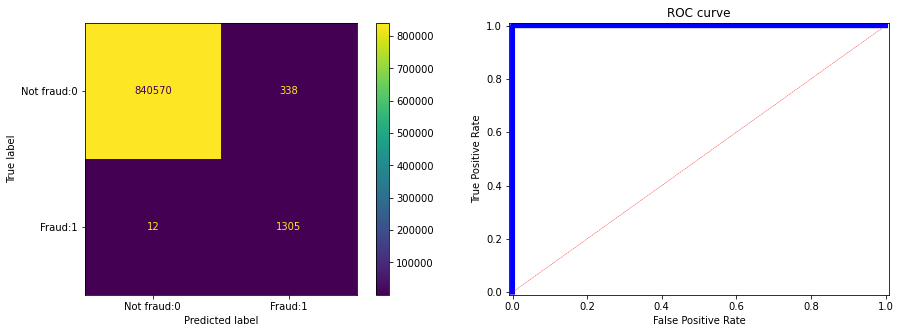

In [ ]:
Credit card transaction is a syntetic financial dataset created using a simulator called PaySim. In this sense, PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.## Final model performance
model_performance_test(y_pred, y_test, y_pred_prob)

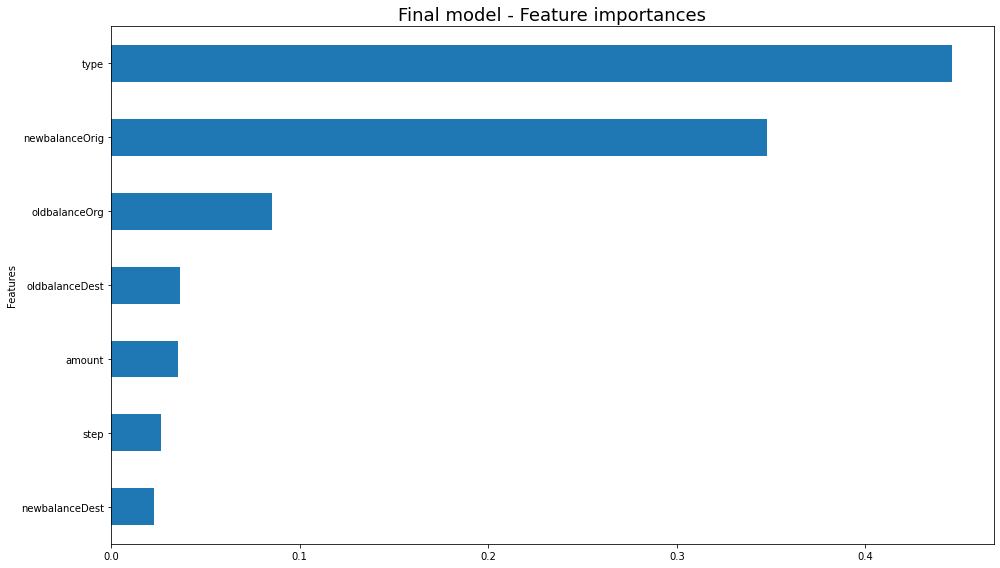

In [ ]:
## Final model - Feature importance
feature_importance = pd.Series(final_model.feature_importances_, index = X_train.columns)

# Plot
plt.figure(figsize = (14, 8))
feature_importance.sort_values(ascending= True).plot(kind = 'barh')
plt.ylabel("Features")
plt.title("Final model - Feature importances", fontsize = 18)

plt.tight_layout();

#### **Observations**
- **In general, the model reaches quite good performance with the test set, achieving an Accuracy of 99.9%.**

- By analyzing the confusion matrix, we can see that the model is so good at identifying both classes Not Fraud(840570 out of 840908) and Churn(1305 out of 1317) with 99.95% and 99.08% observations correctly classified respectly.

- Other metrics that show us the so good performance of the model with both classes:

 - ROC-AUC Score: 0.98

 - F1-Score: 0.98

- The variables that contribute most to the XGBoost final model were:

 - Type of transferent
 - New balance account origin
 - Old balance account origin 

- **These variables could be good predictors to detect fraud in credit card transactions.**

### **Save the model - Serialization**

In [ ]:
modelpath = "/content/drive/MyDrive/Fraud_detection/"
with open(f"{modelpath}/fraud_detection_model-0.0.1.pkl", "wb") as file:
  joblib.dump(final_model, file)